In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
data = pd.read_csv('../data/ntsb/cleaned/master_train.csv')
data = data.loc[(~data['damage'].isna()) & (~data['latitude'].isna())]

In [3]:
def reformat_latitude_longitude(str):
    '''
    Takes string xxxxxxY where:
        x are digits (implied decimal after second digit)
        Y is N/S/E/W 
    Returns latitude/longitude in radians
    '''
    num_as_float = float(str[0:2]+'.'+str[2:-1])
    rads = radians(num_as_float)

    if str[-1] == 'S' or str[-1] == 'W':
        return -rads
    else:
        return rads

In [4]:
#Reformat latitude + longitude to radians; needed for Haversine metric
data['longitude'] = data['longitude'].apply(reformat_latitude_longitude)
data['latitude'] = data['latitude'].apply(reformat_latitude_longitude)

In [5]:
# Train / test split
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data['damage'])

# Baseline model: predict majority
baseline_preds = ['SUBS']*len(data_train)

# Baseline model: probabilities version
# baseline_preds = np.zeros(shape=(len(data),4))
# baseline_preds[:,2] = np.ones(shape=(len(data)))

In [18]:
# Shuffle the data
# Note that GridSearchCV does not shuffle the data before doing StratifiedKFold split
data_shuffled = data_train.sample(frac=1)

X_tr = data_shuffled[['latitude','longitude']]
y_tr = data_shuffled['damage']

params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,20,30]}

grid_search = GridSearchCV(
    KNeighborsClassifier(metric='haversine'),
    params,
    scoring='f1_macro',
    cv=10
)

grid_search.fit(X_tr,y_tr)

,estimator,KNeighborsCla...c='haversine')
,param_grid,"{'n_neighbors': [1, 2, ...]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


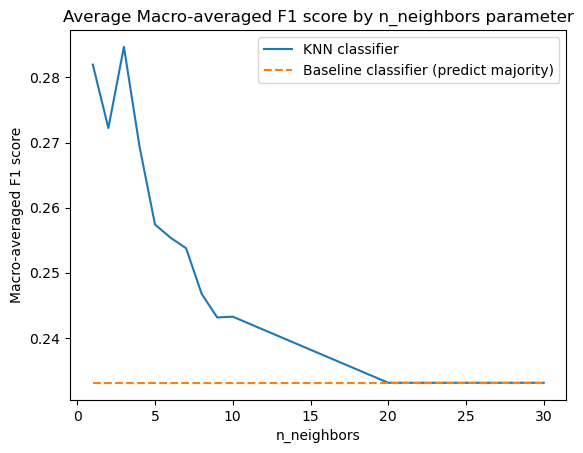

In [19]:
# Get macro-average F1 scores for baseline model and KNN for each parameter value
baseline_score = f1_score(y_tr, baseline_preds, average='macro')
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot macro-average F1 scores
plt.plot(results_df['param_n_neighbors'], results_df['mean_test_score'], label='KNN classifier')
plt.plot(results_df['param_n_neighbors'], baseline_score * np.ones(len(results_df)), 
         label='Baseline classifier (predict majority)', linestyle='--')

# Label the graph
plt.xlabel('n_neighbors')
plt.ylabel('Macro-averaged F1 score')
plt.title('Average Macro-averaged F1 score by n_neighbors parameter')
plt.legend()

plt.show()

### CV Results

I ran the cell above several times to get different shuffles of the dataset. It usually had the highest macro-averaged F1 for `n_neighbors = 1` or `3`

In [16]:
# Fit the model on the full training set
knn = KNeighborsClassifier(n_neighbors=3, 
                           metric='haversine')

knn.fit(X_tr,y_tr)

# Evaluate the model on the test set
X_test = data_test[['latitude','longitude']]
y_test = data_test['damage']

preds = knn.predict(X_test)
np.unique(preds, return_counts=True)

print('Confusion matrix')
print(confusion_matrix(y_test, preds))

print('Macro-averaged F1 score')
print(f1_score(y_test, preds, average='macro'))

Confusion matrix
[[  13    0  204    5]
 [   0    0   22    0]
 [  83    2 2281   21]
 [   3    0   95    5]]
Macro-averaged F1 score
0.26750886403987506


### Further thoughts

I'm not sure this is useful because it predicts 'SUBS' for the vast majority of each damage class. Note that there are only 18 out of ~300 examples where damage is not 'SUBS' and the prediction is correct.

I wanted to tune the hyperparameter k for predicting probabilities rather than predicting a single class, but I had some trouble with the code for this. That might be more useful. It may also be a more useful baseline to predict the proportions of aircraft in each class rather than always predicting the majority class (although this may perform worse, depending on the metric).

Could also try bagging. GridSearchCV would take a really long time to run. May be easier to just do weighted kNN, which should have a similar effect. All of this is really in the fine-tuning world though, if the basic model isn't working too well, I'm not sure how much any of this will help.